<a href="https://colab.research.google.com/github/stwind/notebooks/blob/master/pyro_vae.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -Uq pyro-ppl

     |████████████████████████████████| 614kB 13.4MB/s 


## Setup

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as dset
import torch.distributions as td
import pyro
import pyro.distributions as dist
from torch.utils.data import DataLoader
from torchvision.transforms import Compose, ToTensor, Normalize
from torchvision.utils import make_grid
from torchsummary import summary
from fastprogress.fastprogress import progress_bar
from matplotlib.gridspec import GridSpec

sns.set('notebook', 'darkgrid', rc={
    'font.family': ['DejaVu Sans'],
    'font.sans-serif': ['Open Sans', 'Arial Unicode MS'],
    'font.size': 12,
    'figure.figsize': (8, 5),
    'grid.linewidth': 1,
    'grid.alpha': 0.5,
    'legend.fontsize': 10,
    'legend.frameon': True,
    'legend.framealpha': 0.6,
    'legend.handletextpad': 0.2,
    'lines.linewidth': 1,
    'axes.facecolor': '#fafafa',
    'axes.labelsize': 11,
    'axes.titlesize': 12,
    'axes.linewidth': 0.5,
    'xtick.labelsize': 11,
    'xtick.major.width': 0.5,
    'ytick.labelsize': 11,
    'ytick.major.width': 0.5,
    'figure.titlesize': 13,
})
plt.style.use("dark_background")

print("Infos:")
print("numpy: {}".format(np.__version__))
print("seaborn: {}".format(sns.__version__))
print("matplotlib: {}".format(mpl.__version__))
print("pytorch: {}".format(torch.__version__))
print("pyro: {}".format(pyro.__version__))
for i in range(torch.cuda.device_count()):
    print("cuda device #{}: {}".format(i, torch.cuda.get_device_name(i)))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("current device type: {}".format(device.type))

pyro.enable_validation(True)

Infos:
numpy: 1.19.4
seaborn: 0.11.0
matplotlib: 3.2.2
pytorch: 1.7.0+cu101
pyro: 1.5.1
cuda device #0: Tesla T4
current device type: cuda


## Data

In [4]:
batch_size = 128

transform = Compose([ToTensor()])

ds_train = dset.MNIST("data", train=True, download=True, transform=transform)
ds_test = dset.MNIST("data", train=False, download=True, transform=transform)

train_loader = DataLoader(ds_train, batch_size=batch_size, shuffle=True, num_workers=4)
test_loader = DataLoader(ds_test, batch_size=batch_size, shuffle=True, num_workers=4)

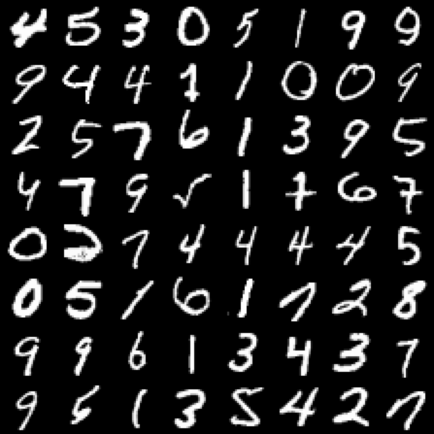

In [5]:
images, _ = next(iter(train_loader))

fig, ax = plt.subplots(figsize=(4,4))

img = make_grid(images[:64], nrow=8, padding=0).permute(1,2,0).numpy()

ax.imshow(img)
ax.set_axis_off()

with plt.rc_context({"savefig.pad_inches": 0}):
    plt.show()

## Model

In [6]:
class Encoder(nn.Module):
    def __init__(self, z_dim, hidden_dim):
        super().__init__()
        self.fc1 = nn.Linear(784, hidden_dim)
        self.fc21 = nn.Linear(hidden_dim, z_dim)
        self.fc22 = nn.Linear(hidden_dim, z_dim)
        self.softplus = nn.Softplus()

    def forward(self, x):
        x = x.view(-1, 784)
        hidden = self.softplus(self.fc1(x))
        z_loc = self.fc21(hidden)
        z_scale = torch.exp(self.fc22(hidden))
        return z_loc, z_scale

    
class Decoder(nn.Module):
    def __init__(self, z_dim, hidden_dim):
        super().__init__()
        self.fc1 = nn.Linear(z_dim, hidden_dim)
        self.fc21 = nn.Linear(hidden_dim, 784)
        self.softplus = nn.Softplus()

    def forward(self, z):
        hidden = self.softplus(self.fc1(z))
        loc_img = torch.sigmoid(self.fc21(hidden))
        return loc_img

    
class VAE(nn.Module):
    def __init__(self, z_dim=50, hidden_dim=400):
        super().__init__()
        self.encoder = Encoder(z_dim, hidden_dim)
        self.decoder = Decoder(z_dim, hidden_dim)

        self.z_dim = z_dim

    # p(x|z)p(z)
    def model(self, x):
        pyro.module("decoder", self.decoder)
        
        with pyro.plate("data", x.shape[0]):
            z_loc = x.new_zeros(self.z_dim)
            z_scale = x.new_ones(self.z_dim)

            z = pyro.sample("latent", dist.Normal(z_loc, z_scale).to_event(1))
            loc_img = self.decoder(z)

            pyro.sample("obs",
                        dist.Bernoulli(loc_img, validate_args=False).to_event(1),
                        obs=x.view(-1, 784))

        return loc_img

    # q(z|x)
    def guide(self, x):
        pyro.module("encoder", self.encoder)
        
        with pyro.plate("data", x.shape[0]):
            z_loc, z_scale = self.encoder(x)
            pyro.sample("latent", dist.Normal(z_loc, z_scale).to_event(1))

## Inference

In [7]:
num_epochs = 20

vae = VAE().to(device)
optimizer = pyro.optim.Adam({"lr": 0.001})
svi = pyro.infer.SVI(vae.model, vae.guide, optimizer, loss=pyro.infer.Trace_ELBO())

In [8]:
pyro.clear_param_store()

train_elbo = []
test_elbo = []

for epoch in progress_bar(range(num_epochs)):
    train_loss = 0.
    for x, _ in progress_bar(train_loader, leave=False):
        x = x.to(device)
        train_loss += svi.step(x)

    train_loss_avg = train_loss / len(train_loader.dataset)
    train_elbo.append(train_loss_avg)
    

    test_loss = 0.
    for x, _ in progress_bar(test_loader, leave=False):
        x = x.to(device)
        test_loss += svi.evaluate_loss(x)

    test_loss_avg = test_loss / len(test_loader.dataset)
    test_elbo.append(test_loss_avg)
        
    print("[{:02d}/{:02d}] train_loss: {:.4f} test_loss: {:.4f}".format(
        epoch, num_epochs, train_loss_avg, test_loss_avg))

[00/20] train_loss: 173.8132 test_loss: 143.5368


[01/20] train_loss: 134.9982 test_loss: 126.3621


[02/20] train_loss: 122.6404 test_loss: 118.2276


[03/20] train_loss: 116.5469 test_loss: 113.4310


[04/20] train_loss: 113.3540 test_loss: 111.4739


[05/20] train_loss: 111.3546 test_loss: 109.7148


[06/20] train_loss: 109.9039 test_loss: 108.6766


[07/20] train_loss: 108.8724 test_loss: 107.4549


[08/20] train_loss: 108.0310 test_loss: 107.1599


[09/20] train_loss: 107.3981 test_loss: 106.4038


[10/20] train_loss: 106.8633 test_loss: 106.0478


[11/20] train_loss: 106.4514 test_loss: 105.7115


[12/20] train_loss: 106.0576 test_loss: 105.5684


[13/20] train_loss: 105.7756 test_loss: 105.3650


[14/20] train_loss: 105.4857 test_loss: 104.8510


[15/20] train_loss: 105.2528 test_loss: 104.7779


[16/20] train_loss: 105.0511 test_loss: 104.6095


[17/20] train_loss: 104.8264 test_loss: 104.3867


[18/20] train_loss: 104.6559 test_loss: 104.2541


[19/20] train_loss: 104.5030 test_loss: 104.0383


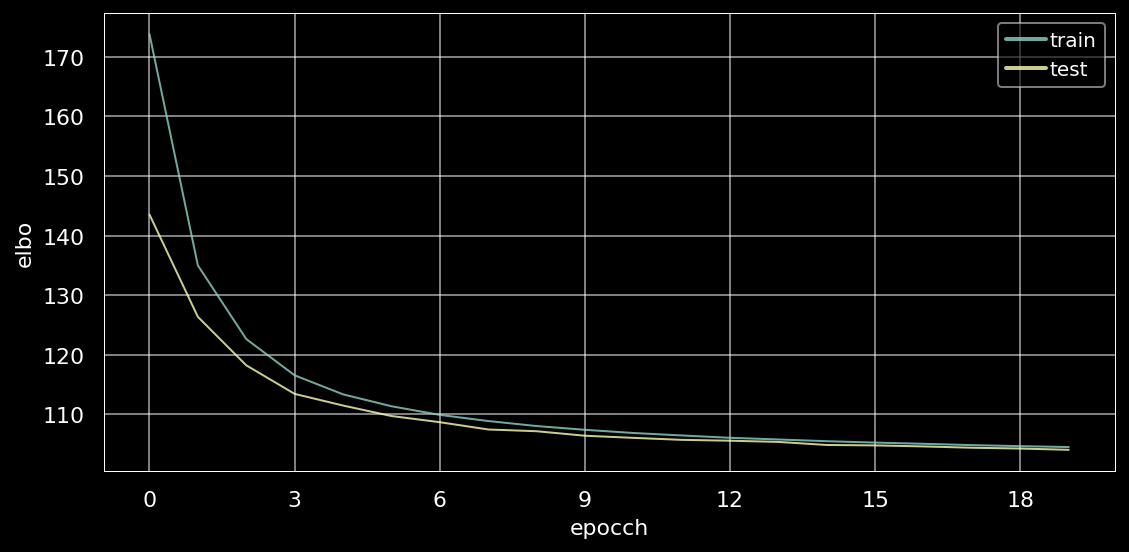

In [9]:
fig, ax = plt.subplots(figsize=(8,4))

ax.plot(train_elbo, label="train", alpha=0.8)
ax.plot(test_elbo, label="test", alpha=0.8)
ax.set(xlabel="epocch",ylabel="elbo")
ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))

leg = ax.legend()
for line in leg.get_lines():
    line.set_linewidth(2.0)

plt.tight_layout()
plt.show()

## Results

In [24]:
batch, _ = next(iter(test_loader))

orig = batch[:10]

z_loc, z_scale = vae.encoder(orig.view(-1,784).to(device))
z = dist.Normal(z_loc, z_scale).sample()
recon = vae.decoder(z).detach().cpu().view(-1,28,28).numpy()

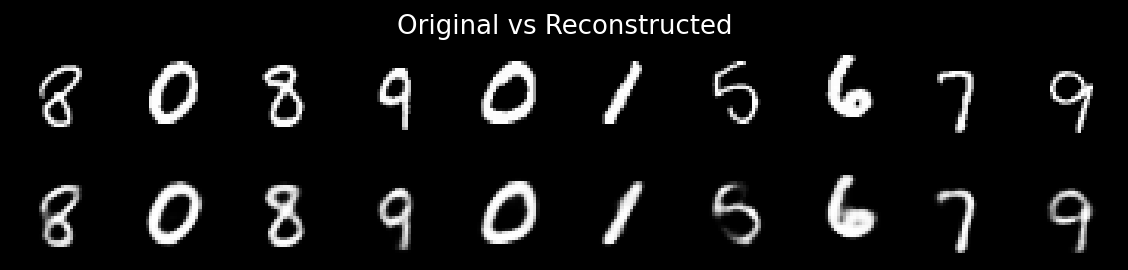

In [26]:
fig, ax = plt.subplots(2, 10, figsize=(8, 2))

for i in range(10):
    ax[0,i].imshow(orig[i].squeeze(0).numpy(), cmap='gray')
    ax[0,i].set_axis_off()

for i in range(10):
    ax[1,i].imshow(recon[i], cmap='gray')
    ax[1,i].set_axis_off()

fig.suptitle("Original vs Reconstructed")
plt.tight_layout()
plt.show()

In [12]:
z = torch.randn(64, 50, device=device)
recon = vae.decoder(z).detach().cpu().view(-1,1,28,28)

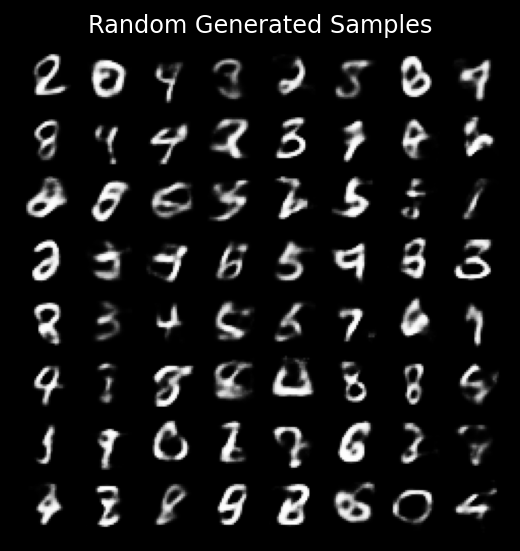

In [14]:
fig, ax = plt.subplots(figsize=(4, 4))

ax.imshow(make_grid(recon,nrow=8).permute(1,2,0).numpy())
ax.set_axis_off()
ax.set_title("Random Generated Samples")

plt.tight_layout()
plt.show()

In [15]:
def slerp(p0, p1, t):
    omega = torch.arccos(torch.dot(p0 / torch.linalg.norm(p0), p1 / torch.linalg.norm(p1)))
    so = torch.sin(omega)
    return torch.sin((1.0 - t) * omega) / so * p0 + torch.sin(t * omega) / so * p1

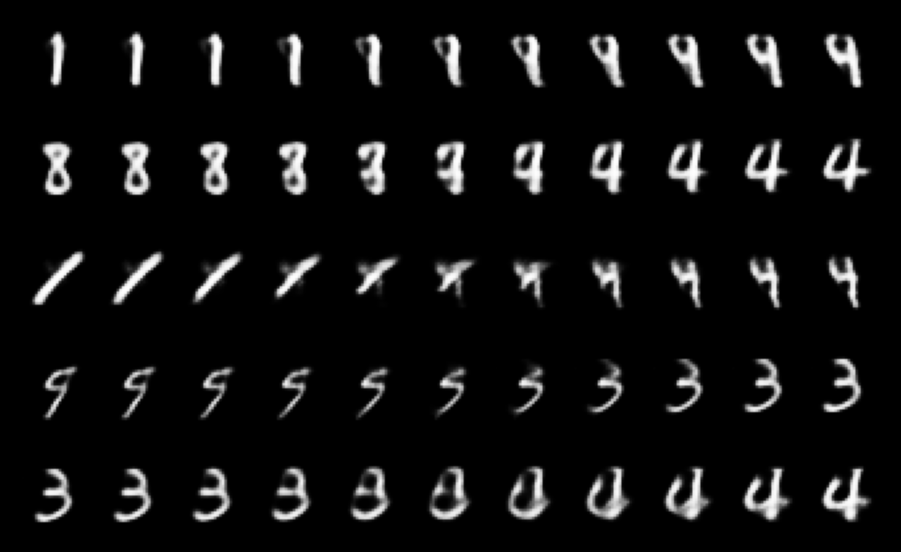

In [23]:
fig, ax = plt.subplots(5, 1, figsize=(8,4))

for i in range(5):
    orig = batch[np.random.randint(0, 64, 2)]
    z_loc, z_scale = vae.encoder(orig.view(-1,784).to(device))
    z1, z2 = dist.Normal(z_loc, z_scale).sample()
    z = torch.cat([slerp(z1, z2, t).unsqueeze(0) for t in np.arange(0,1.1,0.1)], dim=0)
    imgs = vae.decoder(z).detach().cpu().view(-1,1,28,28)

    ax[i].imshow(make_grid(imgs,nrow=11).permute(1,2,0).squeeze(-1).numpy())
    ax[i].set_axis_off()

plt.tight_layout()
plt.show()